# Part 0: Dataloader and Visualizations

In [2]:
import numpy as np
from PIL import Image
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import wandb

from voc_dataset import VOCDataset
from utils import *
%load_ext autoreload
%autoreload 2
USE_WANDB = False

/home/alice/anaconda3/envs/lowergcc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Q0.1: Editing the Dataloader
The first part of the assignment involves editing the dataloader so that we can access bounding-box proposals as well as the ground-truth bounding boxes. The ground truth bounding box can be accessed through the VOC Dataset annotations itself and we have completed this part for you in the starter code. 

Unsupervised bounding box proposals are obtained through methods such as [Selective Search](https://ivi.fnwi.uva.nl/isis/publications/2013/UijlingsIJCV2013/UijlingsIJCV2013.pdf). Since Selective Search is slow to run on each image, we have pre-computed the bounding box proposals for you (you downloaded this in the data preparation step).

Your task is to change the dataloader to obtain the proposed bounding boxes for each image. Feel free to experiment with the data in the files to figure out the number of proposals per image, their scores, etc. Returning a dictionary would be convenient here. For the bounding boxes, using the relative positions is usually a better idea since they are invariant to changes in the size of the image.

In [3]:
dataset = VOCDataset('trainval', top_n=10, data_dir='../../data/VOCdevkit/VOC2007/')

**Q0.1**: Load the image corresponding to index 2020 and print the GT labels associated with it.

**Hint**: items at a particular index can be accesed by usual indexing notation (dataset[idx])

In [3]:
# TODO: get the image information from index 2020
idx = 2020
dataset.roi_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'boxScores', 'boxes', 'images'])

## Q0.2 and Q0.3: Wandb Logging
First, let's initialize a Weights and Biases project. 

In [4]:
USE_WANDB = True
if USE_WANDB:
    wandb.init(project="vlr-hw1", reinit=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: khjune29 (cvl2023). Use `wandb login --relogin` to force relogin


**Q0.2**: Complete this block for overlaying the ground truth box on an image.

**Hint**: convert the image tensor to a PIL image and plot it (check `utils.py` for helper functions). You can use [this](https://docs.wandb.ai/library/log) as a reference for logging syntax.

In [ ]:
class_id_to_label = dict(enumerate(dataset.CLASS_NAMES))

# TODO: load the GT information corresponding to index 2020.
print(dataset[idx].keys())
original_image = dataset[idx]['image']
gt_labels = dataset[idx]['gt_classes']
gt_boxes = dataset[idx]['gt_boxes']

img = wandb.Image(original_image, boxes={
    "predictions": {
        "box_data": get_box_data(gt_labels, gt_boxes),
        "class_labels": class_id_to_label,
    },
})

# TODO: log the GT bounding box


**Q0.3**: Visualize the top 10 bounding proposals corresponding to index 2020.

**Hint**: Check the `get_box_data` function in `utils.py` and understand how it is being used. 

In [28]:
# TODO: plot top ten proposals (of bounding boxes)
idx=2023

print(type(dataset.roi_data['boxes'][0][idx]))
imgs, boxes = [], []
for idx in range(2023, 2026):
    rois = dataset[idx]['rois']
    print(type(rois), type(rois[0][0]))
    imgs.append(tensor_to_PIL(dataset[idx]['image']))
    boxes.append({
        "proposals": {
            "box_data": [
                {
                    "position": {
                        "minX": bbox[0],
                        "minY": bbox[1], #top(min row)
                        "maxX": bbox[2],
                        "maxY": bbox[3], #bottom(max row)
                        },
                    "class_id": 0
                }
                for bbox in rois]
        },
    })
print("prop" , type(boxes[0]["proposals"]["box_data"][0]["position"]["minX"]))
wdb_img = [wandb.Image(img, boxes=box) for img, box in zip(imgs, boxes)]
wandb.log({"region proposals": wdb_img})


<class 'numpy.ndarray'>
<class 'list'> <class 'numpy.float64'>
<class 'list'> <class 'numpy.float64'>
<class 'list'> <class 'numpy.float64'>
prop <class 'numpy.float64'>


Error: You must call wandb.init() before wandb.log()

### debug section

In [103]:
import numpy as np
from utils import nms, tensor_to_PIL, iou
import torch
import torch.nn as nn
from torchvision.ops import box_iou, roi_pool
import torchvision.transforms as transforms


import matplotlib
import matplotlib.pyplot as plt


In [102]:
dataset = VOCDataset('trainval', image_size=512, top_n=10, data_dir='../../data/VOCdevkit/VOC2007/')

train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,   # batchsize is one for this implementation
        shuffle=True,
        pin_memory=True,
        sampler=None,
        drop_last=True)

NameError: name 'VOCDataset' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


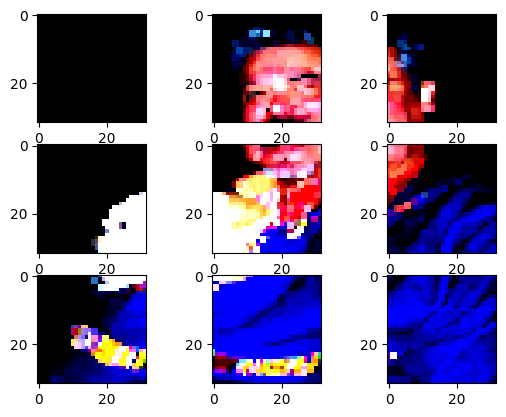

In [11]:
fig, ax = plt.subplots(3, 3)

for iter, data in enumerate(dataset):
    image = data['image']
    target = data['label']
    wgt = data['wgt']
    rois = data['rois']
    gt_boxes = data['gt_boxes']
    gt_class_list = data['gt_classes']
    
    h, w = image.shape[-2:]
    scale_factor = torch.Tensor([w, h, w, h])
    dh = h/3; dw = w/3
    rois = []
    for i in range(3):
        for j in range(3):
            rois.append(torch.Tensor([j*dw, i*dh, (j+1)*dw, (i+1)*dh]))
    rois  = torch.stack(rois, dim=0).float()
    resized = transforms.Resize((112, 112))(image).unsqueeze(0)
    
    proposals = roi_pool(resized, [rois], 32, spatial_scale=112/512)
    proposals = proposals.detach().numpy()
    proposals = proposals.transpose((0, 2, 3, 1))
    for row in range(3):
        for col in range(3):
            ax[row, col].imshow(proposals[row*3+col])
    plt.show()
    break
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

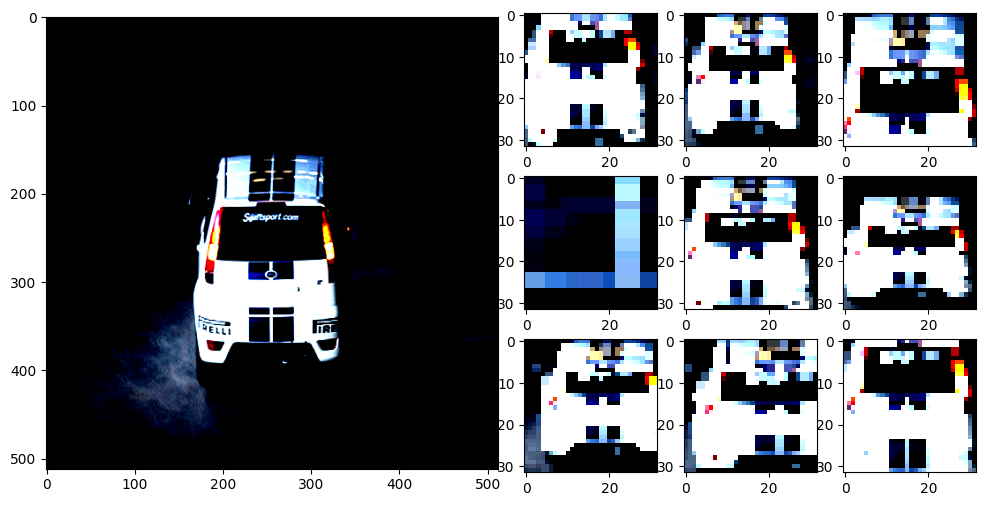

In [56]:
fig=plt.figure(figsize=(12, 6))
ax1 = plt.subplot2grid(shape=(3, 6), loc=(0, 0), colspan=3, rowspan=3)
axes = []
for i in range(1, 10):
    axes.append(plt.subplot2grid((3, 6), loc=((i-1)//3, 3+(i%3)), colspan=1, rowspan=1))

for iter, data in enumerate(dataset):
    # TODO (Q2.2): get one batch and perform forward pass
    # one batch = data for one image
    if iter < 3: continue
    image = data['image']
    target = data['label']
    wgt = data['wgt']
    rois = data['rois']
    gt_boxes = data['gt_boxes']
    gt_class_list = data['gt_classes']
    
    img_transpose = image.transpose(0, 2)
    img_transpose = img_transpose.transpose(0, 1)
    ax1.imshow(img_transpose)
    
    h, w = image.shape[-2:]
    scale_factor = np.asarray([w, h, w, h])
    rois = [
            bbox*scale_factor for bbox in rois
        ]
    rois = torch.Tensor(rois)
    image = transforms.Resize((112, 112))(image).unsqueeze(0)
    
    clips = roi_pool(image, [rois], 32, spatial_scale=112/512) 
    j = -1
    clips = clips.transpose(1, 3)
    clips = clips.transpose(1, 2)
    for i, roi in enumerate(clips):
        if i >= 9: break
        axes[i].imshow(roi)
    
    plt.show()
    
    break

In [64]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [98]:
x = torch.rand(100).numpy()
rv = torch.rand(200).numpy()
detections = [[] for cl in range(5)]
gt_cnts = [[10] for cl in range(5)]
i=0
for conf in x:
    i += 1
    detections[(int)(100*conf)%5].append((conf, 1.0 if conf > 0.5 and rv[i] < 0.7 else 0.0))
class_num = 0 
confidence = sorted(detections[class_num])[::-1]
print(confidence)
corrects = np.array([positive for conf, positive in confidence])
print("correct?", corrects)
pfx = np.cumsum(corrects)
precisions = pfx/(np.arange(len(pfx))+1)
precisions_desc = np.maximum.accumulate(precisions[::-1])[::-1]
print("prec ", precisions)
recalls = pfx/gt_cnts[class_num]
print("recall ", recalls)

[(0.95497686, 1.0), (0.8039009, 1.0), (0.8018651, 0.0), (0.8009079, 1.0), (0.80018896, 1.0), (0.7538183, 1.0), (0.7099753, 0.0), (0.70056266, 0.0), (0.6520061, 0.0), (0.6074113, 1.0), (0.5526066, 1.0), (0.50526935, 1.0), (0.40326166, 0.0), (0.4023221, 0.0), (0.3564155, 0.0), (0.30953026, 0.0), (0.3038215, 0.0), (0.2511257, 0.0), (0.20305336, 0.0), (0.10799146, 0.0), (0.104162335, 0.0), (0.00016051531, 0.0)]
correct? [1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prec  [1.         1.         0.66666667 0.75       0.8        0.83333333
 0.71428571 0.625      0.55555556 0.6        0.63636364 0.66666667
 0.61538462 0.57142857 0.53333333 0.5        0.47058824 0.44444444
 0.42105263 0.4        0.38095238 0.36363636]
recall  [0.1 0.2 0.2 0.3 0.4 0.5 0.5 0.5 0.5 0.6 0.7 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8]


/tmp/ipykernel_19034/2364147037.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


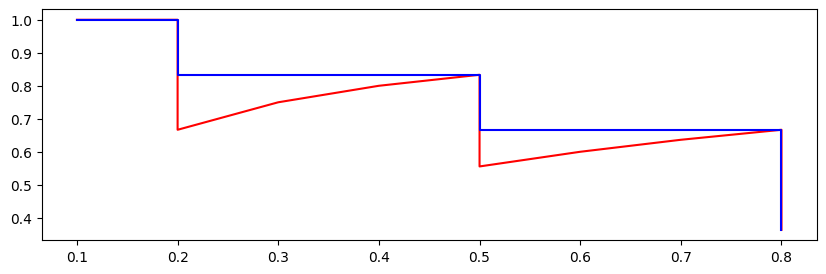

In [99]:
fig, axis= plt.subplots(1, figsize=(10, 3))
axis.plot(recalls, precisions, 'r')
axis.plot(recalls,precisions_desc, 'b')

fig.show()

In [100]:
ap = 0.0; cnt = 0
for recall_tick in np.arange(0.05, 1.05, 0.05):
    i = 0
    while i < len(recalls)-1 and recalls[i] < recall_tick: i += 1
    ap += precisions_desc[i] #recalls[i]~=recall_tick
    cnt += 1
ap /= max(1, cnt)
ap

0.7227272727272724

In [6]:
val_dataset = VOCDataset('test', top_n=300, data_dir='../../data/VOCdevkit/VOC2007/')

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=True)

In [16]:
for iter, data in enumerate(val_loader):
    # TODO (Q2.2): get one batch and perform forward pass
    # one batch = data for one image
    if iter < 3: continue
    image = data['image'].cuda()
    target = data['label']
    wgt = data['wgt']
    rois = data['rois']
    gt_boxes = data['gt_boxes']
    gt_class_list = data['gt_classes']
    
    h, w = image.shape[-2:]
    scale_factor = torch.Tensor([w, h, w, h])
    roi_pix = [
        torch.cat(bbox)*scale_factor for bbox in rois
    ]
    roi_pix  = torch.stack(roi_pix, dim=0).float().cpu()
    cls_probs = torch.rand((300, 20)).cpu()
    # iterate over each class and run nms
    nms_bboxes = []
    for class_num in range(20):
        cls_scores = cls_probs[:, class_num]
        bboxes, scores = nms(roi_pix, cls_scores, 0.3)
        nms_bboxes.extend([{
                    "position": {
                        "minX": bbox[0],
                        "minY": bbox[1], #top(min row)
                        "maxX": bbox[2],
                        "maxY": bbox[3], #bottom(max row)
                        },
                    "class_id": class_num
                } for bbox in bboxes])
        print(nms_bboxes)
    if iter > 3: break

AttributeError: 'numpy.float32' object has no attribute 'int'